# Time Series Clustering

In [1]:
from utilities.std_imports import *
from time_series.clustering.clustering import *

### Generate data

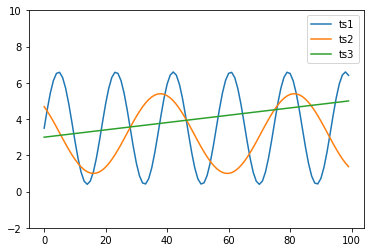

In [2]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

### Distance meassures

In [3]:
print('Euclidean  :\t' , euclid_dist(ts1,ts2))
print('DTW        :\t' , dtw_dist(ts1,ts2))
print('Weight DTW :\t' , wdtw_dist(ts1, ts2, 10))
print('Lbkeogh    :\t' , lbkeogh_dist(ts1, ts2, 10))

Euclidean  :	 26.959216037969345
DTW        :	 17.929718468641138
Weight DTW :	 18.59655183841726
Lbkeogh    :	 10.96456042004128


### Clustering

In [4]:
ts_train = np.genfromtxt('D:/data/csv/ts_train.csv', delimiter='\t')
ts_test = np.genfromtxt('D:/data/csv/ts_test.csv', delimiter='\t')

In [5]:
knn(ts_train,ts_test,4)

'              precision    recall  f1-score   support\n\n         1.0       1.00      0.96      0.98        50\n         2.0       0.96      1.00      0.98        50\n         3.0       1.00      1.00      1.00        50\n         4.0       0.98      1.00      0.99        50\n         5.0       1.00      1.00      1.00        50\n         6.0       1.00      0.98      0.99        50\n\n    accuracy                           0.99       300\n   macro avg       0.99      0.99      0.99       300\nweighted avg       0.99      0.99      0.99       300\n'

1
2
3
4
5
6
7
8
9
10


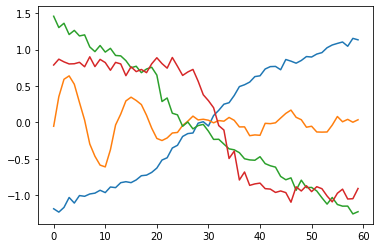

In [14]:
data=np.vstack((ts_train[:,:-1],ts_test[:,:-1]))

centroids = k_means_clust(data=list(data), num_clust=4, num_iter=10 , w=4)

for i in centroids:
    plt.plot(i)

plt.show()

### Credits & Links

https://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb